[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/browndw/humanities_analytics/blob/main/mini_labs/Mini_Lab_05_Results_to_Report.ipynb)

# Mini Lab 5: From Results to Report

Once agin, we're going to use familar libraries and introductory steps in our processing pipeline.

For details about the package and it's functions see: <https://docuscospacy.readthedocs.io/en/latest/docuscope.html>

If you'd like to explore what this library does in an interactive online interface, you can go to: <https://docuscope-ca.eberly.cmu.edu/>

We'll also be using [great_tables](https://posit-dev.github.io/great-tables/articles/intro.html) to design and output tablular data.

## ✅ Task 1: Starting a new Overleaf project

To begin the mini lab, do the following with your team:



1.   Designate a manager for your group.
2.   The manager should make a copy of the CBE Template and name it something like "CBE #2: Practice Report".
3.   The manager should share the report with the other team members.
4.   Add your names and affiliations to the report.

Now let's generate some results to populate the report you've just created.



## Creating a pipeline and preparing data

### Install the packages

Note that the capture decorator simply supresses the installation output.

In [1]:
%%capture
!pip install docuscospacy>=0.3.6
!pip install great_tables

### Install the model

Next we'll install the model.

In [2]:
%%capture
!pip install "en_docusco_spacy @ https://huggingface.co/browndw/en_docusco_spacy/resolve/main/en_docusco_spacy-any-py3-none-any.whl"

### Load the libraries

We'll need these for our proceessing pipeline (docuscospacy, spacy) wrangle data frames (polars), generate and maipulate tables (great_tables) and create plots (matplotlib).

In [3]:
import docuscospacy as ds
import polars as pl
import numpy as np
import spacy
from great_tables import GT, md, html
from matplotlib import pyplot as plt

### Mount your Google Drive

This chunk will allow you to save outputs directly to your Drive.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Import data

For this exercise, we'll a down-sampled version of the [Human-AI Parallel Corpus in English](https://huggingface.co/datasets/browndw/human-ai-parallel-corpus-mini) (HAP-E).

In [4]:
df = pl.read_parquet("hf://datasets/browndw/human-ai-parallel-corpus-mini/hape_mini-text.parquet")

Rember that the table has a `doc_id` column and a `text` column. This is conventional formatting for processing textual data.

In [ ]:
df.head()

doc_id,text
str,str
"""gpt4_acad_0005""","""This inherent fascination with…"
"""gpt4_acad_0031""","""This approach allows us to not…"
"""gpt4_acad_0036""","""Moreover, while turn-final cue…"
"""gpt4_acad_0038""","""In doing so, we aimed to unrav…"
"""gpt4_acad_0045""","""In exploring the domain of com…"


For the purposes of this mini lab, it is also useful to note what the categories are that have been encoded into the `doc_id`. To retrive that information, we can extract the initial character string and return the unique values. This information will be useful later.

In [ ]:
df.get_column("doc_id").str.extract(r"^([a-z0-9]+)", 1).unique().sort().to_list()

['gpt4', 'human', 'llama']

So this corpus has data generated by human writers, by ChatGPT and by Llama Instruct.

### Load the model

As with any processing task of this kind, we will first need to load a model instance.

In [5]:
nlp = spacy.load("en_docusco_spacy")

### Process the corpus

Now, we pass our data frame `df` to the nlp model that we just loaded using the `docuscope_parse` function. This is the most computationally intensive part of the process (and it takes the longest). For this sample corpus, processing should take a couple of minutes.

In [6]:
ds_tokens = ds.docuscope_parse(df, nlp_model=nlp, n_process=4)

Performance: Corpus processing completed in 35.97s


### Peek at the tokens

Now we can check what we've generated.

In [ ]:
ds_tokens.head()

doc_id,token,pos_tag,ds_tag,pos_id,ds_id
str,str,str,str,u32,u32
"""gpt4_acad_0005""","""This ""","""DD1""","""MetadiscourseCohesive""",1,1
"""gpt4_acad_0005""","""inherent ""","""JJ""","""AcademicTerms""",2,2
"""gpt4_acad_0005""","""fascination ""","""NN1""","""Positive""",3,3
"""gpt4_acad_0005""","""with ""","""IW""","""Untagged""",4,4
"""gpt4_acad_0005""","""the ""","""AT""","""Untagged""",5,5


## Creating a corpus compostition table for our report

Look at [this table](https://huggingface.co/datasets/browndw/human-ai-parallel-corpus-mini#corpus-composition) summarizing the content of this corpus.

Let's see if we can recreate it.

### Aggregating counts

The first step is to aggregate counts of features. We'll start by filtering out punctuation marks from are parsed data.

Note in the `pos_tag` column there is a designation for puctuation marks which is **Y**.

In [ ]:
ds_tokens.filter(pl.col("pos_tag") == "Y").head()

doc_id,token,pos_tag,ds_tag,pos_id,ds_id
str,str,str,str,u32,u32
"""gpt4_acad_0005""",""", ""","""Y""","""Untagged""",16,14
"""gpt4_acad_0005""",""", ""","""Y""","""Untagged""",26,21
"""gpt4_acad_0005""",""". ""","""Y""","""Untagged""",33,26
"""gpt4_acad_0005""",""", ""","""Y""","""Untagged""",51,40
"""gpt4_acad_0005""",""", ""","""Y""","""Untagged""",59,46


So, we'll want to filter those OUT.

In [7]:
mini_total = ds_tokens.filter(pl.col("pos_tag") != "Y")

Next, we want to extract the name of the creator of text and put that into a column called `Author` and the text-type which we'll put into a column called `text_type`. The first comes from the initial string before the underscore, and the second between the underscores.

This is how we do that

In [8]:
mini_total = mini_total.with_columns(
    pl.col("doc_id").str.extract(r"^([a-z0-9]+)_", 1).alias("Author"),
    pl.col("doc_id").str.extract(r"_(\S+)_", 1).alias("text_type")
    )

The `[a-z0-9]+` matches any sequence of letters or numbers and the `_(\S+)_` any non-space between underscores.

And check the result...

In [ ]:
mini_total.head()

doc_id,token,pos_tag,ds_tag,pos_id,ds_id,Author,text_type
str,str,str,str,u32,u32,str,str
"""gpt4_acad_0005""","""This ""","""DD1""","""MetadiscourseCohesive""",1,1,"""gpt4""","""acad"""
"""gpt4_acad_0005""","""inherent ""","""JJ""","""AcademicTerms""",2,2,"""gpt4""","""acad"""
"""gpt4_acad_0005""","""fascination ""","""NN1""","""Positive""",3,3,"""gpt4""","""acad"""
"""gpt4_acad_0005""","""with ""","""IW""","""Untagged""",4,4,"""gpt4""","""acad"""
"""gpt4_acad_0005""","""the ""","""AT""","""Untagged""",5,5,"""gpt4""","""acad"""


Now we need to summarize by counting how many tokens there are by `Author` and by `text_type`. For this we'll need to `group_by` and then aggregate our counts.

We'll also need to count the number of texts or documents in each category.

In [9]:
mini_total = (mini_total
              .group_by(["Author"])
              .agg(pl.col("token").len().alias("Tokens"), # get a count of tokens using length or len
                   pl.col("doc_id").n_unique().alias("Texts")) # get a count of documents by counting the unique doc ids
              )

And check the result....

In [ ]:
mini_total.head()

Author,Tokens,Texts
str,u32,u32
"""gpt4""",489242,900
"""human""",446997,900
"""llama""",454023,900


And check the result...

Looks good, but let's make our `Author` names a little nicer.

In [10]:
mini_total = (mini_total
              .with_columns(
                  pl.col("Author")
                  .str.replace("llama", "Llama 8B Instruct")
                  .str.replace("gpt4", "ChatGPT 4o")
                  .str.replace("human", "Human")
                  )
              ).sort("Author")

And check our final data frame...

In [ ]:
mini_total.head()

Author,Tokens,Texts
str,u32,u32
"""ChatGPT 4o""",489242,900
"""Human""",446997,900
"""Llama 8B Instruct""",454023,900


We can also create totals for our data by summing our `Tokens` and `Texts` columns.

In [12]:
grand_summary_row = mini_total.select(
    pl.lit("TOTALS").alias("Author"),
    pl.exclude("Author").sum())

Note that we can concatenate our totals and our summary:

In [ ]:
pl.concat([mini_total, grand_summary_row])

Author,Tokens,Texts
str,u32,u32
"""ChatGPT 4o""",489242,900
"""Human""",446997,900
"""Llama 8B Instruct""",454023,900
"""TOTALS""",1390262,2700


### Saving a great table

Next, we'll convert our data frame into a table that we can save and display in our report.

We'll be using [**great_tables**](https://posit-dev.github.io/great-tables/articles/intro.html).

So here's a simple version of your table:

In [13]:
(
    GT(pl.concat([mini_total, grand_summary_row])) # create the table
    .fmt_integer(columns=pl.exclude("Author")) # format the rest of the columns
    )

Author,Tokens,Texts
ChatGPT 4o,"489,243",900
Human,"446,991",900
Llama 8B Instruct,"454,026",900
TOTALS,"1,390,260","2,700"


That looks like what we want. So let's generate our LaTeX...

In [ ]:
(
    GT(pl.concat([mini_total, grand_summary_row])) # create the table
    .fmt_integer(columns=pl.exclude("Author")) # format the rest of the columns
    ).as_latex()

'\\begin{table}[!t]\n\n\n\\fontsize{12.0pt}{14.4pt}\\selectfont\n\n\\begin{tabular*}{\\linewidth}{@{\\extracolsep{\\fill}}lrr}\n\\toprule\nAuthor & Tokens & Texts \\\\ \n\\midrule\\addlinespace[2.5pt]\nChatGPT 4o & 489,242 & 900 \\\\\nHuman & 446,997 & 900 \\\\\nLlama 8B Instruct & 454,023 & 900 \\\\\nTOTALS & 1,390,262 & 2,700 \\\\\n\\bottomrule\n\\end{tabular*}\n\n\\end{table}\n'

## ✅ Task 2: Add a new table to your report



1.   Go to the tables directory in your new Overleaf project.
2.   Click on the 3 dots to the right and click on New File.
3.   Name the file something like "hape_mini_composition" with the ".tex" extension.
4.   Add a caption and a label. (Use the "corpus_composition" file as an example.
5.   Replace the place-holder "corpus_composition" table in the report with the table you've just created.



## Creating a plot for our report

For our plot, well begin with a `keyness_table`.

See here: <https://docuscospacy.readthedocs.io/en/latest/corpus_analysis.html#Keyword-tables>

For our target, we'll use the ChatGPT-generated data, and for our reference the human-generated data. First, we'll select the data that we want.

In [14]:
gpt_tokens = ds_tokens.filter(pl.col("doc_id").str.contains("gpt"))
human_tokens = ds_tokens.filter(pl.col("doc_id").str.contains("human"))

Now we'll create a tags table.

In [15]:
gpt_tags = ds.tags_table(gpt_tokens, count_by="ds")
human_tags = ds.tags_table(human_tokens, count_by="ds")

And finally we can generate our keyness table, setting `tags_only=True`.

In [16]:
gpt_vs_human = ds.keyness_table(gpt_tags, human_tags, tags_only=True)

Check the table.

In [ ]:
gpt_vs_human.head()

Tag,LL,LR,PV,RF,RF_Ref,AF,AF_Ref,Range,Range_Ref
str,f64,f64,f64,f64,f64,u32,u32,f64,f64
"""Positive""",2150.544727,0.781545,0.0,5.213627,3.032994,20858,10486,100.0,99.666667
"""Description""",794.730077,0.280912,7.5482e-175,12.487658,10.278222,49959,35535,100.0,100.0
"""AcademicTerms""",778.647621,0.424818,2.3688e-171,5.630057,4.194012,22524,14500,100.0,99.777778
"""InformationChangePositive""",765.513396,1.773273,1.6993e-168,0.511164,0.149538,2045,517,77.666667,36.0
"""InformationChange""",644.974772,0.912459,2.7670e-142,1.201549,0.638358,4807,2207,97.111111,78.777778


For a trial plot, we'll create a bar plot. We start by selecting the data we want to plot: the `Tag`, `RF` and `RF_Ref` columns. The latter are our frequencies in the ChatGPT- and Human-generated text respectively.

Then, we need to specify our label locatations and bar widths.

Finally, we create horizontal bars and plot.

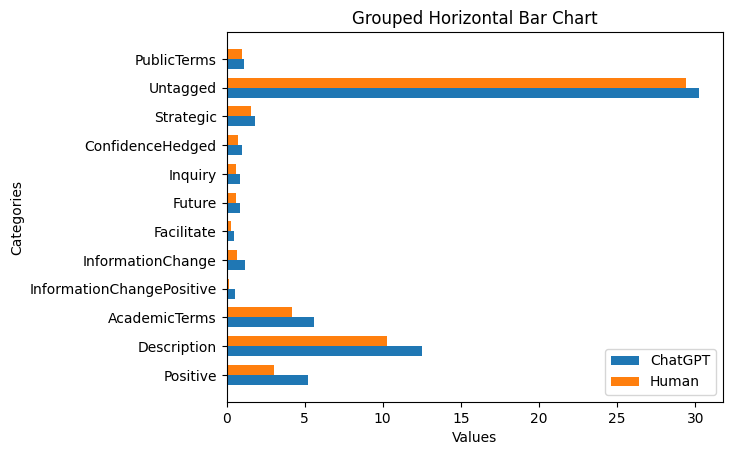

In [ ]:
fig, ax = plt.subplots()
categories = gpt_vs_human.get_column("Tag").to_numpy()
group1_values = gpt_vs_human.get_column("RF").to_numpy()
group2_values = gpt_vs_human.get_column("RF_Ref").to_numpy()

y_pos = np.arange(len(categories))  # the label locations
bar_width = 0.35  # the width of the bars

bar1 = ax.barh(y_pos - bar_width/2, group1_values, bar_width, label='ChatGPT')
# Create bars for group 2
bar2 = ax.barh(y_pos + bar_width/2, group2_values, bar_width, label='Human')

# Set y-axis labels and ticks
ax.set_yticks(y_pos)
ax.set_yticklabels(categories)

# Add labels and title
ax.set_xlabel('Values')
ax.set_ylabel('Categories')
ax.set_title('Grouped Horizontal Bar Chart')

# Add legend
ax.legend()

Okay, but not exactly something we'd put in a report. Let's concentrate our focus on categories with the highest effect sizes. We'll create a new data frame and filter only those categories with a Log Ratio greater than 0.5.

In [17]:
plot_df = (gpt_vs_human
 .sort("RF", descending=False)
 .filter(pl.col("LR") > .5))

And check the data.

In [ ]:
plot_df

Tag,LL,LR,PV,RF,RF_Ref,AF,AF_Ref,Range,Range_Ref
str,f64,f64,f64,f64,f64,u32,u32,f64,f64
"""Facilitate""",210.478468,0.800498,1.0801e-47,0.489668,0.281143,1959,972,78.888889,59.111111
"""InformationChangePositive""",765.513396,1.773273,1.6993e-168,0.511164,0.149538,2045,517,77.666667,36.0
"""Future""",174.159103,0.520567,9.1378e-40,0.867605,0.604805,3471,2091,94.555556,81.111111
"""InformationChange""",644.974772,0.912459,2.7670e-142,1.201549,0.638358,4807,2207,97.111111,78.777778
"""Positive""",2150.544727,0.781545,0.0,5.213627,3.032994,20858,10486,100.0,99.666667


Now let's plot that data. We'll also put the ChatGPT data first and make better axes labels.

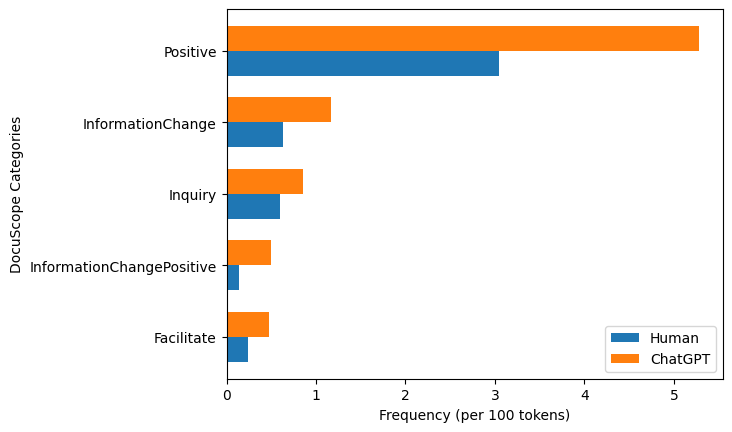

In [18]:
fig, ax = plt.subplots()
categories = plot_df.get_column("Tag").to_numpy()
group1_values = plot_df.get_column("RF").to_numpy()
group2_values = plot_df.get_column("RF_Ref").to_numpy()

y_pos = np.arange(len(categories))  # the label locations
bar_width = 0.35  # the width of the bars

# Create bars for group 2
bar1 = ax.barh(y_pos - bar_width/2, group2_values, bar_width, label='Human')
# Create bars for group 2
bar2 = ax.barh(y_pos + bar_width/2, group1_values, bar_width, label='ChatGPT')

# Set y-axis labels and ticks
ax.set_yticks(y_pos)
ax.set_yticklabels(categories)

# Add labels and title
ax.set_xlabel('Frequency (per 100 tokens)')
ax.set_ylabel('DocuScope Categories')

# Add legend
ax.legend()

That looks good for now, so let's save it to your Drive.

When you run this chunk be sure to set your own path where it currently: `'/content/drive/MyDrive/76-380-780 MiHA/Mini Labs/output/gpt_vs_human.png'`

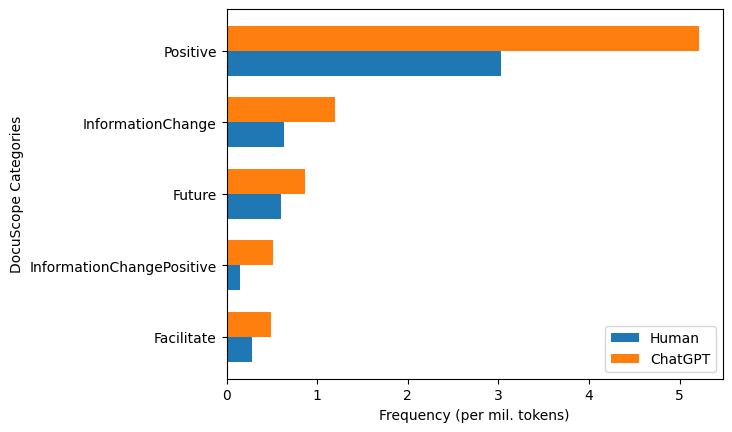

In [ ]:
fig, ax = plt.subplots()
categories = plot_df.get_column("Tag").to_numpy()
group1_values = plot_df.get_column("RF").to_numpy()
group2_values = plot_df.get_column("RF_Ref").to_numpy()

y_pos = np.arange(len(categories))  # the label locations
bar_width = 0.35  # the width of the bars

# Create bars for group 2
bar1 = ax.barh(y_pos - bar_width/2, group2_values, bar_width, label='Human')
# Create bars for group 2
bar2 = ax.barh(y_pos + bar_width/2, group1_values, bar_width, label='ChatGPT')

# Set y-axis labels and ticks
ax.set_yticks(y_pos)
ax.set_yticklabels(categories)

# Add labels and title
ax.set_xlabel('Frequency (per 100 tokens)')
ax.set_ylabel('DocuScope Categories')

# Add legend
ax.legend()

# fig.savefig('/content/drive/MyDrive/76-380-780 MiHA/Mini Labs/output/gpt_vs_human.png', bbox_inches='tight')


## ✅ Task 3: Add the plot to the report

Now that you've saved the plot to your drive, you can add it to your Overleaf report:



1.   Download the file from Drive.
2.   Go to the Figures directory in your project and upload the file.
3.   Replace the place-holder figure with the new one.
4.   Add an appropriate caption.



## Unpacking the result

How might you begin to investigate what is happening with these differences in frequencies?

Let's start with something simple. Let's create a keyword list and look at the "Positive" category.

In [ ]:
gpt_ds = ds.frequency_table(gpt_tokens, count_by="ds")
human_ds = ds.frequency_table(human_tokens, count_by="ds")
keywords_ds = ds.keyness_table(gpt_ds, human_ds)

Let's look at those with the highest effect sizes.

In [ ]:
keywords_ds.filter(pl.col("Tag") == "Positive").sort("LR", descending=True).head(10)

Token,Tag,LL,LR,PV,RF,RF_Ref,AF,AF_Ref,Range,Range_Ref
str,str,f64,f64,f64,f64,f64,u32,u32,f64,f64
"""resilience""","""Positive""",242.900874,8.396739,9.1664e-55,487.418357,0.0,195,0,17.666667,0.0
"""camaraderie""","""Positive""",94.669058,7.037336,2.2503e-22,189.96818,0.0,76,0,8.0,0.0
"""genuine""","""Positive""",77.230021,6.743605,1.5216e-18,154.974042,0.0,62,0,6.0,0.0
"""advancements""","""Positive""",117.333711,6.461834,2.4261e-27,254.957295,2.892422,102,1,8.777778,0.111111
"""embracing""","""Positive""",62.282275,6.433265,2.9759e-15,124.979066,0.0,50,0,5.111111,0.0
"""promise of""","""Positive""",96.520434,6.198799,8.8327e-23,212.464412,2.892422,85,1,9.0,0.111111
"""empathy""","""Positive""",49.82582,6.111336,1.6802e-12,99.983253,0.0,40,0,4.222222,0.0
"""resilient""","""Positive""",44.843238,5.959333,2.1346e-11,89.984928,0.0,36,0,3.888889,0.0
"""clarity""","""Positive""",78.221564,5.918691,9.2108e-19,174.970692,2.892422,70,1,6.888889,0.111111


We can also use KWIC (or Key Words in Context) to see how these are being expressed in the text.

In [ ]:
ds.kwic_center_node(gpt_tokens, "resilience")

Doc ID,Pre-Node,Node,Post-Node
str,str,str,str
"""gpt4_acad_0100""","""innovations that safeguard aga…","""resilience ""","""against political and economic…"
"""gpt4_acad_0202""","""understanding of these complex…","""resilience ""","""in forested landscapes at the …"
"""gpt4_acad_0242""","""hinges on nuanced local adapta…","""resilience ""","""of localized knowledge bases. …"
"""gpt4_acad_0250""","""a range of conditions to stren…","""resilience ""","""and reliability under differen…"
"""gpt4_acad_0256""","""establishment of ecological fu…","""resilience""",""". Moreover, the socio-economic…"
…,…,…,…
"""gpt4_tvm_0715""","""with eyes like hawks and a ste…","""resilience ""","""born from their adventures, wh…"
"""gpt4_tvm_0893""","""-all these experiences, all th…","""resilience ""","""built, were preparation. For s…"
"""gpt4_tvm_0900""","""his eyes reflecting a kindred …","""resilience""",""". ""We'll see what tomorrow """


## ✅ Task 4: Developing an analysis and intrpretation

Do some exploring on your own. You can add new code chunks by clicking on the `+ Code` option at the bottom of an existing one. Then, with your team:


1.   In the Results section, add a few sentences that describe/report the results from the figure (the bar plot) that you've just added.
2.   In the Discussion section, sketch out some provisional interpretation and/or framing. What are you seeing here? What do you make of it?
3.   If you were to develop this into a more fully realized report, what would your team do next?
4.   When you've complete this, render the PDF, save it, and upload it to Canvas.



## 🤔 Discussion Questions

1. **Academic Communication**: How do the choices of formatting and presentation in great_tables influence how readers interpret your findings? What responsibility do you have in making results accessible?

2. **Effect Size vs. Statistical Significance**: When filtering keywords by Log Ratio (effect size), we chose 0.5 as a threshold. How would using a different threshold (e.g., 0.3 or 0.7) change the story your visualization tells? What are the trade-offs?

3. **Visual Rhetoric**: The bar plot shows "Positive" as dramatically more frequent in ChatGPT text. How might the choice of plot type (bar vs. scatter vs. heatmap) affect readers' perception of the magnitude of this difference?

4. **From Results to Interpretation**: When you examined KWIC concordances for "resilience," what patterns did you notice in how ChatGPT uses this word? How does close reading inform or complicate the statistical patterns?

5. **Reproducibility in Reporting**: This lab walks you through creating LaTeX tables and saving figures to integrate with Overleaf. Why is this workflow important for computational humanities research compared to copying/pasting screenshots?

6. **Corpus Composition Decisions**: The HAP-E corpus balances human, ChatGPT, and Llama texts. How would unbalanced corpus sizes (e.g., 1000 human texts vs. 100 AI texts) affect the reliability of your keyness comparisons?

## 💡 Experimentation Ideas

1. **Table Styling**: Explore great_tables documentation to add column spanners, color-coding, or footnotes to your corpus composition table. How do these enhancements improve clarity?

2. **Alternative Visualizations**: Create a different plot type for the same data (e.g., a stacked bar chart, diverging bar chart, or even a word cloud of keywords). Which visualization best serves your analytical goals?

3. **Multiple Comparisons**: Instead of just GPT vs. Human, create keyness tables for Llama vs. Human and GPT vs. Llama. What patterns emerge across all three comparisons?

4. **Threshold Sensitivity Analysis**: Create plots with different LR thresholds (0.3, 0.5, 0.7, 1.0) and save them all. How does the narrative change as you become more or less selective?

5. **Token-Level Analysis**: Modify the analysis to use `ds.frequency_table()` with `count_by="token"` instead of tags. What specific words (rather than categories) distinguish ChatGPT from human writing?

6. **Export Formats**: Experiment with saving your plots in different formats (PNG, PDF, SVG) and at different resolutions. How does file format affect how the image appears in your final report?